## Time to test some students (statistical modelling)

![Interior of a classroom, students bent at study, Yallourn, 1947.](museums-victoria-n1LIveUPls4-unsplash.jpg)

Some while ago I read a fantastic book titled [Modelling mindsets](https://christophmolnar.com/books/modeling-mindsets/) by Christoph Molnar. It prompted an idea to reiterate on a problem that is as old as any stastician's playbook: student exams.
Writing exams is difficult, but  statistician may claim, modelling an exam result is fairly trivial.
Bear with me for a bit, and you'll see there is more to it than you might expect.

### Exam scores

Exam scores are a popular choice in many statistican textbooks. It is largely accepted that they follow a normal distribution (hence the term student's t-test). As they saying goes, *the proof of the pudding is in the eating*. We will use a dataset of 1000 fictional exams created with [Rocye Kimmon's excellent exam scores generator](http://roycekimmons.com/tools/generated_data/exams).

In [1]:
from IPython.display import display, HTML
import pandas as pd

df = pd.read_csv("exams.csv")
df["overall score"] = df[["math score", "reading score", "writing score"]].mean(axis=1)
display(HTML(df.head().to_html(index=False)))

gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,overall score
female,group A,some high school,standard,none,43,52,53,49.333333
female,group E,high school,free/reduced,none,58,53,54,55.000000
male,group C,associate's degree,standard,none,66,72,68,68.666667
female,group D,associate's degree,standard,none,76,86,85,82.333333
male,group C,master's degree,standard,none,68,70,69,69.000000


For good measure we should perform a visual inspection of our data as well.

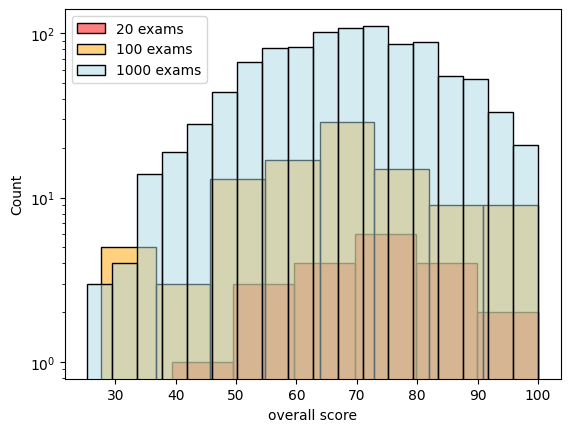

In [2]:
#| label: fig-student-exam-distributions
#| fig-cap: "Different sample sizes of a fictional student exam dataset"

import seaborn as sns
import matplotlib.pyplot as plt

colors = ["red", "orange", "lightblue"]
sizes = [20, 100, 1000]

fig, ax = plt.subplots()
for size, color in zip(sizes, colors):
    dist = df.sample(size, random_state=42)
    sns.histplot(dist["overall score"], ax=ax, log_scale=(False, True), alpha=0.5, color=color, label=f"{size} exams")

ax.legend()
plt.show()

From above's chart we can see that our chosen distribution captures our experiment more approximately with a larger sample size. This is unsurprising to a degree that it nowadays is an accepted platitude for anyone who came within two inches close to statistics.

## Lets get some measuring tape (frequentism)

If it is so evident that our chosen distribution approximates our experiment, just **how** large does the sample size needs to be?
What sounds like an innocent question, could be the substance of ample discussion. For all but the simplest experiments, science usually resorts to empiricism. Experiments are repeated until *we think they do what we need them to do*.

![Girl wearing reflective pink sunglasses with an excited facial expression](thomas-park-KYEeuGUkZ54-unsplash.jpg)

Being a linguist by profession, this is the preferrential paradigm I have been thaught, as well as for much of modern evidence-guided scientific research. The playbook for estimating evidence is relatively well established. You'll have to stick to the following steps in order:

1. Formulate a hyphothesis
2. Observe some data in the wild
3. Perform a hyphothesis test suitable to your hypothesis
4. Estimate a confidence interval ("how certain can you be that you're really certain?")

On to it then, let's not waste any more of our precious time! 🚆

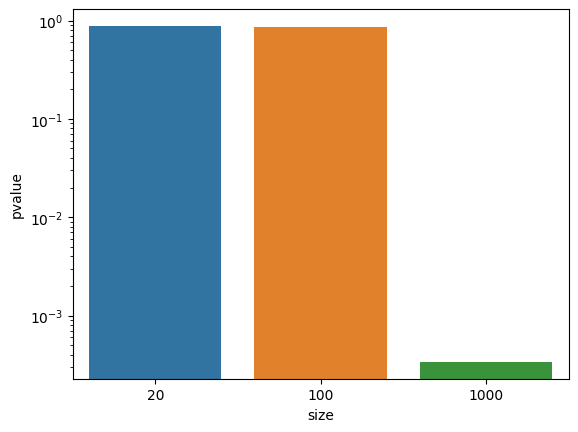

In [3]:
#| label: fig-sample-draw-confidence-interval
#| fig-cap: "Confidence intervals for different sample sizes of a fictional student exam dataset"

import numpy as np
import scipy.stats as stats

rows = []

for size in sizes:
    x = df.sample(size, random_state=42)["overall score"]
    k2, p = stats.normaltest(x)
    rows.append((size, p, k2))

test_df = pd.DataFrame(rows, columns=["size", "pvalue", "statistic"])

fig, ax = plt.subplots()
ax.set(yscale="log")
ax = sns.barplot(data=test_df, x="size", y="pvalue", ax=ax)
#ax.errorbar(data=test_df, x="size", y="mean", yerr="sd", ls='', lw=3, color="black")
plt.show()

We formulate our null hyphothesis of exam scores following a *normal* distribution. We then perform a Pearson test for different samples sizes of the original distribution. This test returns a 2-sided chi squared probability for every sample. If the significance level of `p = 0.05` is not reached, we would reject the null hyphothesis. In our example this is the case only for `n = 1000`.

## From assumptions to assertions (Baayesian statistics)

Since we have a firm theoretical understanding of exams, another way to infer model parameters could be used. We could assume the distribution of student exam scores to be a normal distribution (our prior distribution). We use the observed sample to adjust the prior distribution, which yields the posterior distribution. We can then use this updated distributions to make predictions for us.
This solution is elegant when the problem is well studied, and the parameters of the model vary naturally (a student's score distribution is a fine example). To illustrate, we set the prior mean to `65` and the standard deviation to `10` (from visual inspection). We can use `pymc3` to obtain a posterior, and plot this against the original data.

In [4]:
import logging
logger = logging.getLogger('pymc3')
logger.propagate = False

from IPython.utils import io
from scipy.stats import norm
import pymc as pm

# Define prior parameters from visual inspection
prior_mean = 65  # Prior mean
prior_std = 10   # Prior standard deviation
data = df["overall score"]

def posterior_distribution(mu, sigma, sample: np.ndarray) -> tuple[float, float]:
    # Define the model
    with pm.Model() as model:
        # Define prior distributions
        prior_mean_dist = pm.Normal('prior_mean', mu=mu, sigma=sigma)
        # If the population standard deviation (σ) is known, you can specify it here as a constant.
        # If it's unknown, you can use a prior distribution for σ as well.
    
        # Define likelihood (assuming a normal distribution for the sample)
        likelihood = pm.Normal('likelihood', mu=prior_mean_dist, sigma=np.std(data), observed=data)
    
        # Perform inference
        trace = pm.sample(len(data))  # Run MCMC sampling
        return trace.posterior.prior_mean.mean().item(), trace.observed_data.likelihood.std().item()

# Generate x values for plotting
x = np.linspace(0, 100, 100)

# Calculate the prior and posterior distributions
prior_dist = norm.pdf(x, loc=prior_mean, scale=prior_std)
with io.capture_output(stdout=True, stderr=True, display=True) as captured:
    posterior_mean, posterior_std = posterior_distribution(prior_mean, prior_std, df["overall score"])
    posterior_dist = norm.pdf(x, loc=posterior_mean, scale=posterior_std);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_mean]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


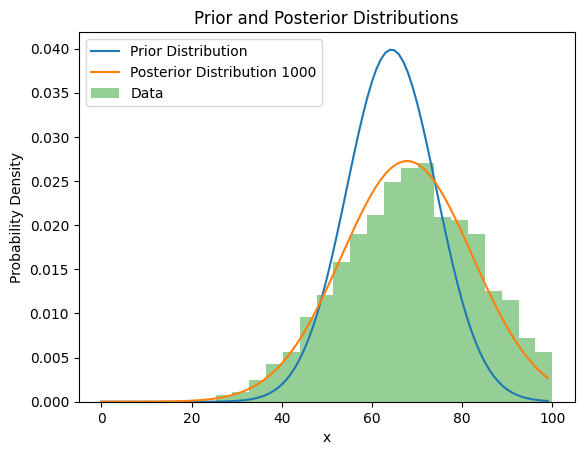

In [5]:
#| label: fig-bayesian
#| fig-cap: "Prior, posterior and actual data distribution of a fictional exam dataset"

# Plot the prior and posterior distributions
plt.plot(prior_dist, label='Prior Distribution')
plt.plot(posterior_dist, label=f'Posterior Distribution {size}')
plt.hist(data, bins=20, density=True, alpha=0.5, label='Data')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Prior and Posterior Distributions')
plt.legend()
plt.show()

This shows us that, for well-studied problems we can approximate them statistically, which saves us time and compute. As previously demonstrated, the larger the sample, the better.

## One evidence to rule them all: likelihoodism

Taking the previous ideas one step further we could postulate that observation alone serves as the true source of modelling. This idea can be formulated as **likelihoodism**. It's conceptually elegant. No need to postulate hyphotheses or test them. We can infer the parameters of our experiment right from observations. This is really useful if we are doing validation research on a new class of known problems.

As with any modelling approach, likelihoodism also has its own class of problems. Notably, when can we stop measuring? How many samples are sufficient? How do we make sure we are not prone to observation bias? In cases where we have a firm theoretical understanding of the phenomena we want to observe, its possible to answer these questions. If we want to determine the lifetime behaviour of mechanical parts, we can clearly specify how many hours of usage the part is designed to handle. We can test that amount of hours. The data will speak to itself as to the correctness of the engineering.

In other cases this is almost impossible to estimate.
If we want to add common sense facts to our modelling, rather than relying on observation alone, we can turn to causal statistic.

## Causality

Causal statistics has been responsible for a lot of noise in the scientific community recently, and for good reason. As Christoph put it:

> I guess we all have an intuition about causality. Rain is a cause of a wet lawn.

Our student exam example entails some causal relationships as well:

![Effects on exam scores](./Exam_score.png)

This makes intuitive sense. We can use hyphothesis tests to estimate how pronounced the effects of our cause are. When we can be reasonably certain that we eliminated different possible biases, causality can be an excellent tool to model some classes of problems. 

As we encode our domain knowledge into an algorithm, all we need to do is to specify a set of rules (e.g a finite state automaton). Causal inference is computationally cheap and explainable.

However, as the problems we are trying to model grow in complexity, causality can become unwieldy to adapt. As always, we need to carefully evaluate if our chosen paradigm can fit to the problem at hand.

## From explanation to machine learning

The first six chapters of modelling mindsets are dedicated to describing data. A radically different approach is to demand our computers to do the work for us. For instance, we can ask the computer to learn the relationship between _parental level of education_ and _overall score_. To model this problem, we should first map the education level to categorical values (essentially numbers), which are understandable for computers.

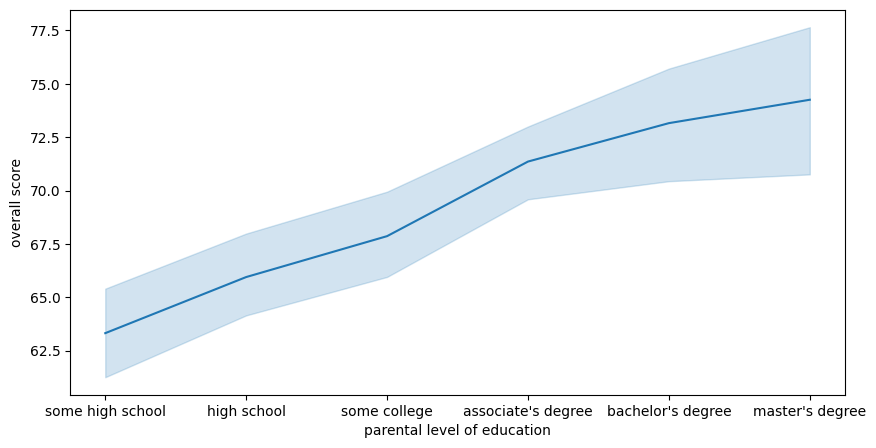

In [6]:
#| label: fig-parent-edu-score
#| fig-cap: "Relation between parental level of education and overall score of a fictional exam dataset"
sort_values = {
    "some high school": 0, "high school": 1, "some college": 2, "associate's degree": 3,
    "bachelor's degree": 4, "master's degree": 5
}

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    df.sort_values(by=["parental level of education"], key=lambda x: x.map(sort_values)), 
    x="parental level of education", 
    y="overall score", 
    ax=ax
)
plt.show()

This figure suggests that `parental level of education` is a good predictor for a student's `overall score`. To test if that is true, we may create a linear model to predict the `overall score` from the student's `parental level of education`. In order to do so we follow well-established steps

1. Preprocess your data
   1. Inspect input and discard defect rows
   2. Encode variables numerically
   3. Scale or normalise your data
2. Split your data into training, testing and possibly validation (cross-fold if we are being vigilent)
3. Pick your model (in our case we suggest a linear model)
   1. Pre-estimate hyperparameters on a development set using hyperparameter exploration
4. Train your model
5. Evaluate your model and report a useful metric for your problem (for classification this is usually [F-metric](https://en.wikipedia.org/wiki/F-score))

Since the machine learning playbook is well known that's exactly what we will be doing.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

le = LabelEncoder()
y = le.fit_transform(df["parental level of education"])

X_train, X_test, y_train, y_test = train_test_split(
    df[["math score", "reading score", "writing score"]], 
    y, 
    test_size=0.2,
    random_state=123
)

clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

with io.capture_output(stdout=True, stderr=True, display=True) as captured:
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
display(HTML(pd.DataFrame(report).to_html()))

,associate's degree,bachelor's degree,high school,master's degree,some college,some high school,accuracy,macro avg,weighted avg
precision,0.328767,0.0,0.0,0.0,0.241071,0.333333,0.28,0.150529,0.185583
recall,0.615385,0.0,0.0,0.0,0.529412,0.138889,0.28,0.213948,0.280000
f1-score,0.428571,0.0,0.0,0.0,0.331288,0.196078,0.28,0.159323,0.203344
support,39.000000,18.0,42.0,14.0,51.000000,36.000000,0.28,200.000000,200.000000


Teaching this to a machine isn't as trivial as it appears. Our F1 score is `0.28`, so we are a lot worse than simply guessing the parent's level of education.
Upon closer inspection of the input data, we find our old nemesis (sample size) at work again. With 18% of the data representing bachelor's and master's degrees, it is unsurprising that the algorithm has a difficult time to differentiate students into 6 classes.

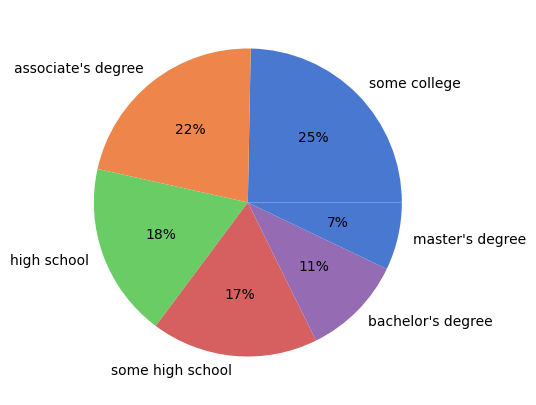

In [8]:
#| label: fig-student-parental-education-distribution
#| fig-cap: "Percentage of student by their parental education level"

from collections import Counter
counter = Counter(df["parental level of education"])
labels, sizes = zip(*counter.most_common())

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("muted")[0:5]
ax.pie(sizes, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

This example highlights some of the unique benefits and issues that one has to consider when opting for a machine learning model:

- we need to have good domain understanding of the input variables, and even so, some problems cannot trivially be learned
- machine learning algorithms are data hungry
- they can help us quickly build useful things (most of the code for this classifier was just copy-pasted from the scikit documentation)

Luckily we are not restricted to supervised learning. There's a treasure trove of methods which can aid us make sense of data. This is where unsupervised learning comes into play (consequently, semi-supervised learning may combine the best of both worlds).

## Unsupervised learning

If we wanted to inspect the relations between `gender`, `race`, `parental education` and `lunch` in relation to the overall score, we can use a `pairplot` to make some sense of our data. However, discovering patterns between these confound variables is not trivial. This is where unsupervised algorithms can come in handy. As always, when in doubt, visualize the data first.

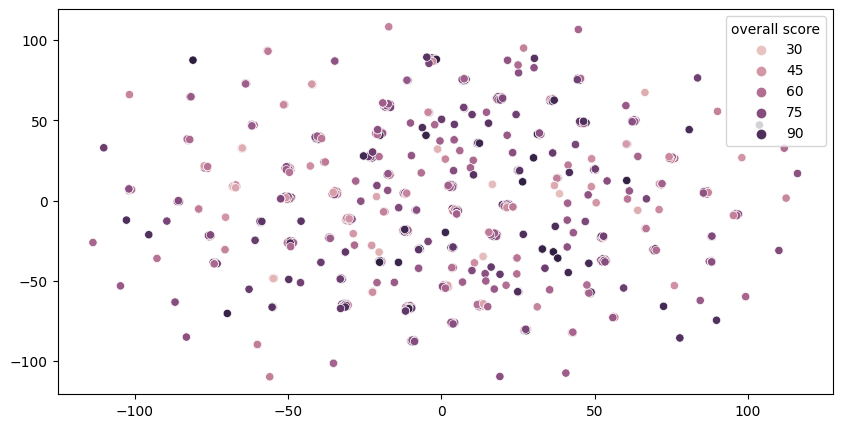

In [9]:
#| label: fig-manifold
#| fig-cap: "Manifold representation of different variables and in relation to overall score"
from sklearn.manifold import TSNE

encoded_df = pd.DataFrame()
for column in ["race/ethnicity", "lunch", "parental level of education", "gender", "test preparation course"]:
    encoder = LabelEncoder()
    encoded_df[column] = encoder.fit_transform(df[column].values)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(encoded_df)
x, y = zip(*X_embedded)

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=x, y=y, hue=df["overall score"])
plt.show()

If this data leaves you clueless, you're not alone. There aren't any obvious groups to be found. Therefore, one possible conclusion is that our variables are independant. Since this is a pet dataset, it may very well be the case. If we want to be good data scientists, we should follow up on this intuition and look at the correlation of different variables. We may do so using a correlation heatmap.

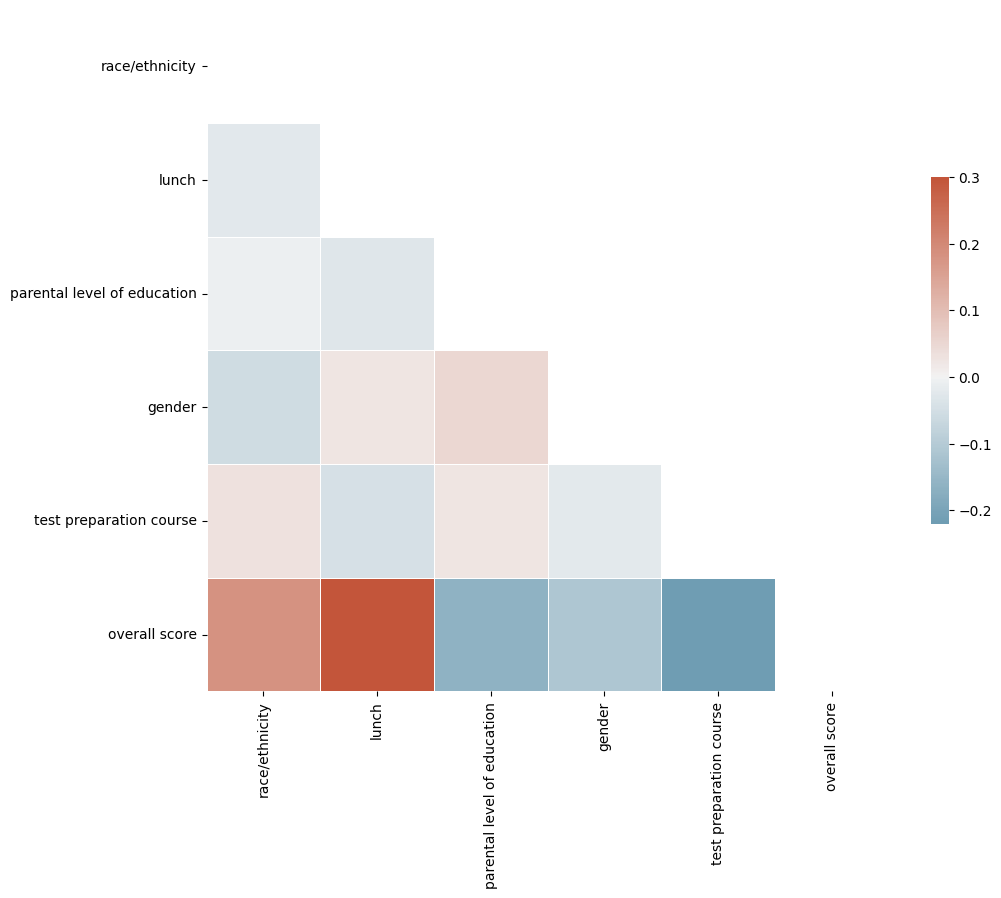

In [10]:
#| label: fig-correlation-heatmap
#| fig-cap: "Heatmap of correlations between different variables"

# Compute the correlation matrix
encoded_df["overall score"] = df["overall score"]
corr = encoded_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

As suspected, there is no significant correlation between the different variables. Further, the correlation heatmap reveals that we should have trained our predictor on the relation between `lunch` and `overall score`, which appears to be strongly correlated. Unfortunately, improving our predictor beyond using the `lunch` variable will be difficult. If other variables are indeed strictly independant, this will also rule out _additive and linear mixed models_.

## Learning to test (deep learning)

So, we've exhausted the statisticians playbook, but we're not quite done yet. There are other things still that we can try!
Instead of making explicit assumptions about the distribution of our input, we can try and ask our computer to do even more work for us. We can do so by using neural networks, which _"just do the work for us"_. This is a strong simplification of all the empirical research which goes into neural networks. For the sake of illustration however, we can rerun our previous classifier as a neural network. `scikit-learn` lends us an implementation of the multi layer perceptron, which is very easy to plug into our previous classification example. We train our `MLPClassifier` on the variables `race/ethnicity` and `lunch` and ask it to predict the resulting `overall_score` in American grading scale for us.

In [11]:
from sklearn.neural_network import MLPClassifier


def grade(score: float) -> str:
    if score >= 90:
        return "A"
    elif score >= 80 and score < 90:
        return "B"
    elif score >= 70 and score < 80:
        return "C"
    elif score >= 60 and score < 70:
        return "D"
    else:
        return "E"


X_train, X_test, y_train, y_test = train_test_split(
    encoded_df[["race/ethnicity", "lunch"]], 
    encoded_df["overall score"].map(grade),
    test_size=0.33,
    random_state=123
)

clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

with io.capture_output(stdout=True, stderr=True, display=True) as captured:
    report = classification_report(y_test, y_pred, target_names=["A", "B", "C", "D", "E"], output_dict=True)
display(HTML(pd.DataFrame(report).to_html()))

,A,B,C,D,E,accuracy,macro avg,weighted avg
precision,0.0,0.182927,0.324324,0.342105,0.385185,0.318182,0.246908,0.293663
recall,0.0,0.384615,0.130435,0.309524,0.641975,0.318182,0.293310,0.318182
f1-score,0.0,0.247934,0.186047,0.325000,0.481481,0.318182,0.248092,0.282078
support,34.0,39.000000,92.000000,84.000000,81.000000,0.318182,330.000000,330.000000


Indeed, our perceptron classifier can learn a stronger relation between our input variables and the resulting grade. `A` students however appear to be non-existent. We know this cannot be true, as the support is 34 (and therefore there are `A` students). This showcases some of the unique strengths and weaknesses of deep learning algorithms. We are able to train a classifier which outperforms our linear model out of the box. As to why it has issues with some classes however is difficult to interpret (at best). One way to inspect the model can be:

- look at the final hidden state
- plot a heatmap
- identify which neurons permanently stay (de)activated

Let's try our best with the `MLPClassifier` we just trained.

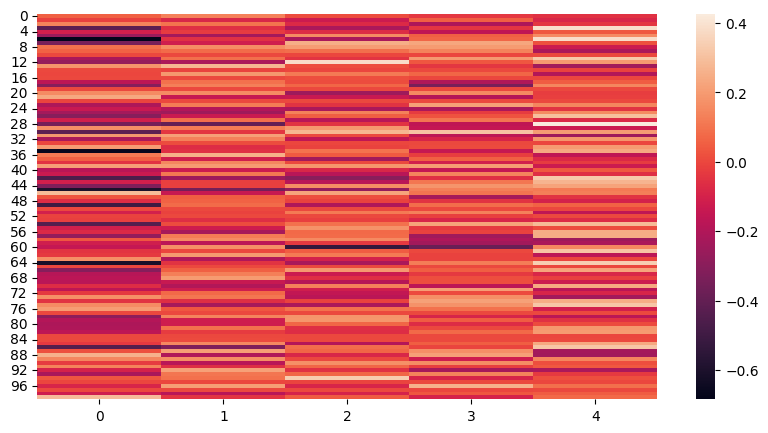

In [12]:
#| label: fig-perceptron-output-layer
#| fig-cap: "Heatmap of perceptron output"

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(clf.coefs_[-1], ax=ax)
plt.show()

The heatmap shows us that:

- for category 0 (`class A`) we have strong activations (yet it isn't predicted?)
- for category 0 we have activations all across the board (this is probably bad)
- for other categories we have strong activations around the _60th_ layer
- generally the activations are sparse and we can't really see any patterns emerge

As with other paradigms, there are classes of problems where only deep neural networks can help (think of LLMs, image generation etc). This comes at the price of interpretability. Where we could clearly (and completely) explain our linear model, doing the same for a deep neural network is fairly difficult.

## Conclusion (t-shaped modeler)

My takeaway from __modelling mindsets__ is to stay pragmatic and open to all the branches of computational statistics. Different problems require different solutions. In this sense, it is best to become an expert on any one of the areas introduced (the one most useful or enjoyable to you). In the same sense, if you have become an expert, your routine way of modelling can not apply to everything, and you are free to lend any (or all) of the other areas of computational statistics to help you solve the issue at hand.

Certainly I have learnt my fair share by just building out the different sections of this blog post, solidifying my own expertise and entering other areas that I am not usually as confident in. It was a fun ride! [Lastly, if you haven't bought the book yet, you should](https://christophmolnar.com/books/modeling-mindsets/).

### Reinforcement learning

In the __modelling mindsets__ book, chapter 9 is reserved for reinforcement learning. While certainly very interesting and deserving of its own chapter, I found it not to be applicable to the data at hand. We don't know the questions of the exam, so we can't really simulate its results. If you do have an idea how this would be modelled, please drop me a mail!